In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
file_path = '../data/heart.csv'

heart_df = pd.read_csv(file_path)
display(heart_df.head())

In [6]:
#Tenemos una combinación de características numéricas y categóricas.
# Las características categóricas (objetos) deberán codificarse antes de
# poder utilizarlas en nuestro modelo
heart_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


--FASE EXPLORATORIA DE DATOS--

In [7]:
#fase de exploracion de datos.
#Estadisitica descriptiva de mi dataset, Buscamos OUTLIERS) max,min,mean etc
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


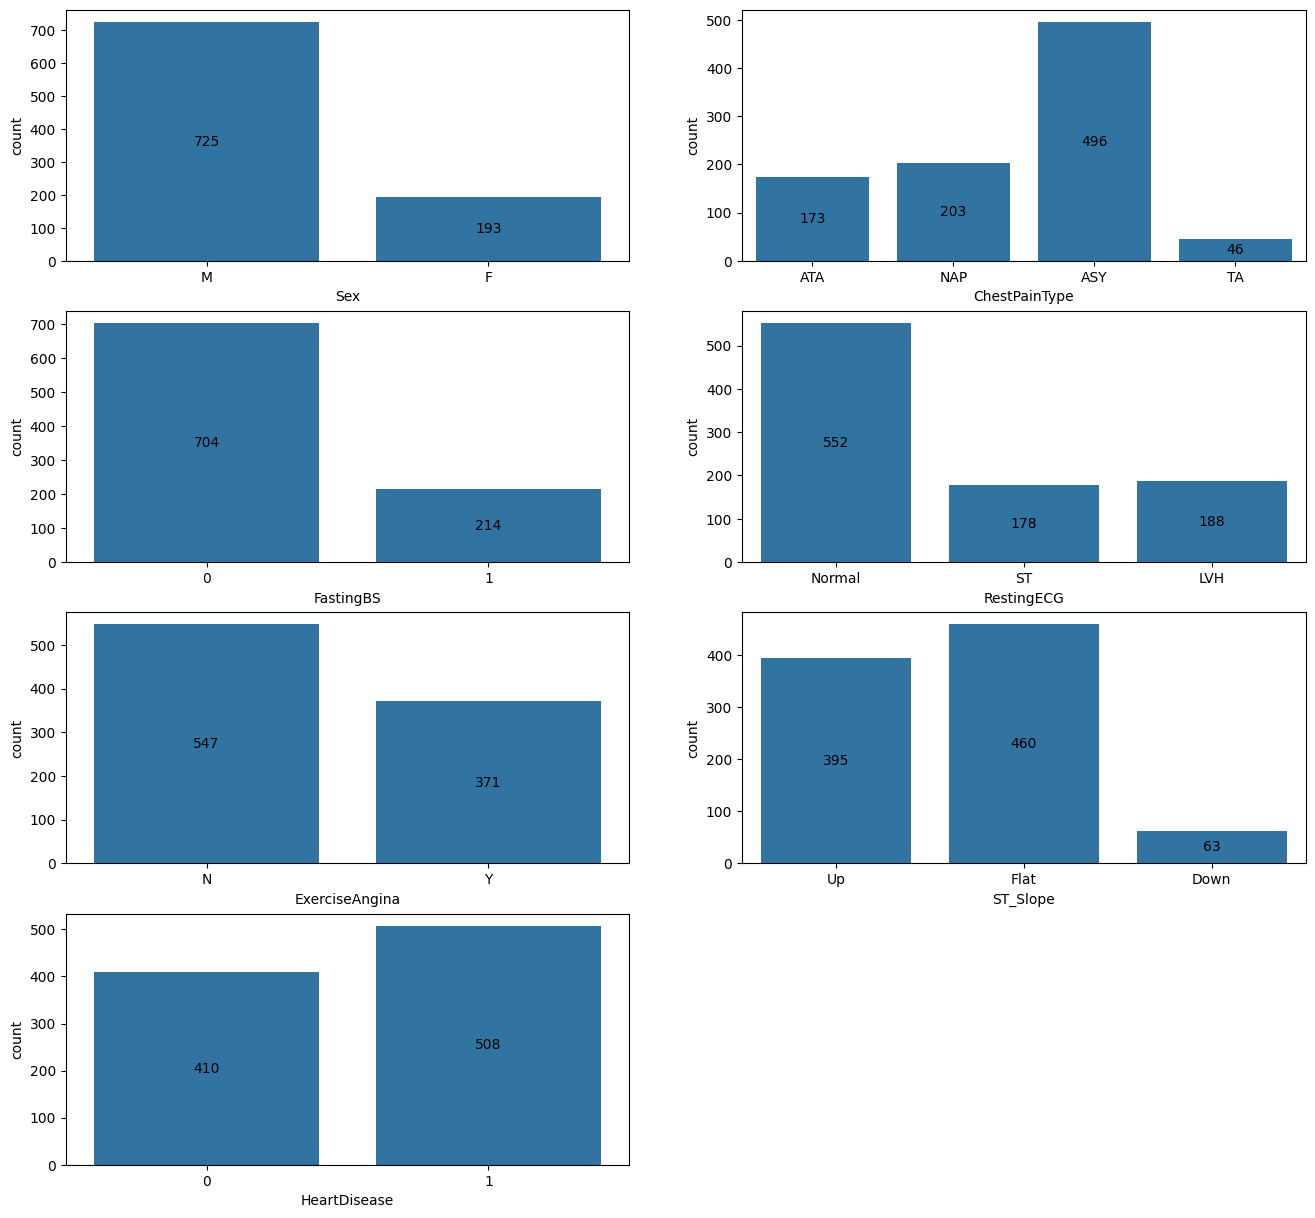

In [8]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=heart_df[col], ax=ax)
    # AÑADIR ETIQUETAS DE DATOS A CADA BARRA/ Countplot nos ayuda a esto
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Estos gráficos de recuento nos permiten comprender la distribución de nuestras variables categóricas:
- Sexo: El conjunto de datos contiene significativamente más hombres (725) que mujeres (193).
- Tipo de dolor torácico: «ASY» (asintomático) es el tipo de dolor torácico más común.
- Glucemia en ayunas: La mayoría de los pacientes tienen niveles normales de glucosa en sangre en ayunas (0).
- ECG en reposo: «Normal» es el resultado más común.
- Angina de pecho inducida por el ejercicio: La mayoría de los pacientes no experimentan angina de pecho inducida por el ejercicio.
- Pendiente del segmento ST: «Plana» y «Ascendente» son las más comunes, con muy pocos casos «Descendentes».
- Cardiopatía: La variable objetivo está razonablemente equilibrada, con una ligera mayoría de casos positivos.

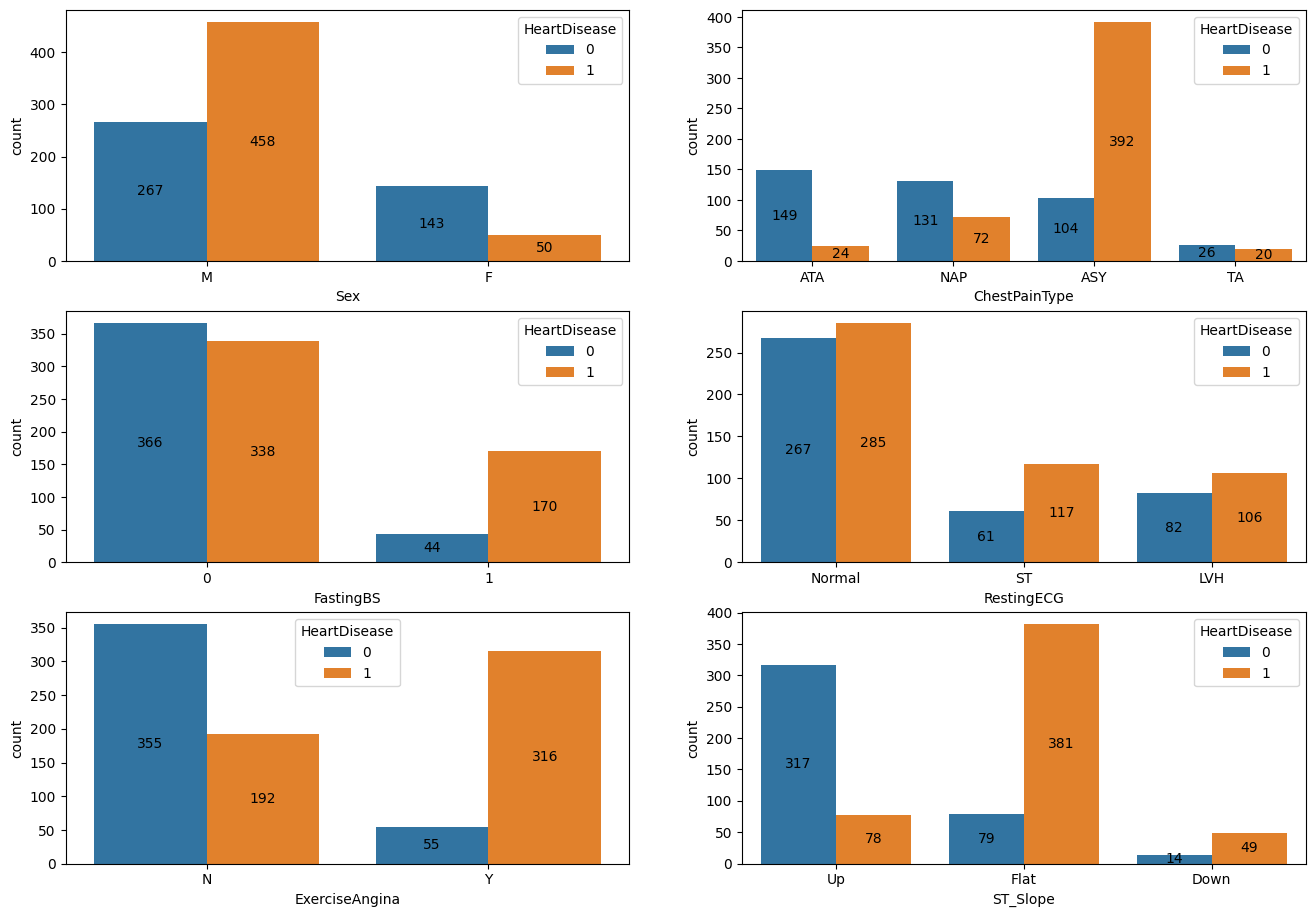

In [9]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=heart_df[col], hue=heart_df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Estas visualizaciones revelan varios patrones interesantes:
Sexo: Los hombres presentan una mayor prevalencia de cardiopatía en este conjunto de datos.
- Tipo de dolor torácico: El dolor asintomático (ASY) se asocia fuertemente con cardiopatía.
- Glucosa en ayunas: La glucemia en ayunas elevada se asocia con cardiopatía.
- ECG en reposo: El tipo ST se asocia más con cardiopatía que el tipo normal.
- Angina de pecho inducida por el ejercicio: Existe una fuerte asociación entre la angina de pecho inducida por el ejercicio (tipo Y) y la cardiopatía.
- Pendiente del segmento ST: La pendiente plana se asocia fuertemente con cardiopatía, mientras que la pendiente ascendente se asocia con la ausencia de cardiopatía.

In [10]:
heart_df[heart_df['RestingBP']==0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 449 to 449
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1 non-null      int64  
 1   Sex             1 non-null      object 
 2   ChestPainType   1 non-null      object 
 3   RestingBP       1 non-null      int64  
 4   Cholesterol     1 non-null      int64  
 5   FastingBS       1 non-null      int64  
 6   RestingECG      1 non-null      object 
 7   MaxHR           1 non-null      int64  
 8   ExerciseAngina  1 non-null      object 
 9   Oldpeak         1 non-null      float64
 10  ST_Slope        1 non-null      object 
 11  HeartDisease    1 non-null      int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 104.0+ bytes


Solo hay un paciente con una presión arterial en reposo de 0, lo cual es claramente un error de entrada de datos o un valor faltante. Ahora revisemos el colesterol:

In [11]:
heart_df[heart_df['Cholesterol']==0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 293 to 536
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             172 non-null    int64  
 1   Sex             172 non-null    object 
 2   ChestPainType   172 non-null    object 
 3   RestingBP       172 non-null    int64  
 4   Cholesterol     172 non-null    int64  
 5   FastingBS       172 non-null    int64  
 6   RestingECG      172 non-null    object 
 7   MaxHR           172 non-null    int64  
 8   ExerciseAngina  172 non-null    object 
 9   Oldpeak         172 non-null    float64
 10  ST_Slope        172 non-null    object 
 11  HeartDisease    172 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 17.5+ KB


Tenemos 172 pacientes con un valor de colesterol de 0, lo que representa aproximadamente el 19 % de nuestro conjunto de datos. Se trata de una cantidad significativa de registros, por lo que deberemos manejar estos valores con cuidado.
Limpiemos nuestros datos mediante:
1. Eliminar el registro con presión arterial en reposo = 0.
2. Reemplazar los valores de colesterol = 0 con el valor mediano de colesterol, calculado por separado para pacientes con y sin cardiopatía.

---LIMPIEZA DE DATOS---

In [12]:
#Creamos una copia para no correr el riesgo de error en el viejo o nuevo dtaframe
df_clean = heart_df.copy()

# Eliminar el registro con RestingBP = 0
df_clean = df_clean[df_clean["RestingBP"] != 0]

# Crear una mascarilla para pacientes sin enfermedad cardíaca
heartdisease_mask = df_clean["HeartDisease"]==0

# Obtenga los valores de colesterol para pacientes con y sin enfermedad cardíaca
cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

# Reemplazar los valores de colesterol = 0 con la mediana del grupo correspondientedf_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())
df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())


# Verifica que la limpieza haya funcionado
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


Ahora que nuestros datos están limpios, debemos prepararlos para nuestro modelo de aprendizaje automático. El algoritmo de los K vecinos más cercanos requiere entradas numéricas, por lo que necesitaremos convertir nuestras variables categóricas. Utilizaremos la codificación one-hot para transformar estas variables a formato numérico:



In [13]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Coeficiente de correlación de Pearson, EN VALORES ABS
### Análisis de Correlación
Para medir la relación lineal entre las variables, utilizaremos el **Coeficiente de Correlación de Pearson**, definido por la fórmula:

$$r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2 \sum(y_i - \bar{y})^2}}$$

Donde:
* $r$: Coeficiente de correlación.
* $x_i, y_i$: Valores individuales.
* $\bar{x}, \bar{y}$: Medias de las variables.

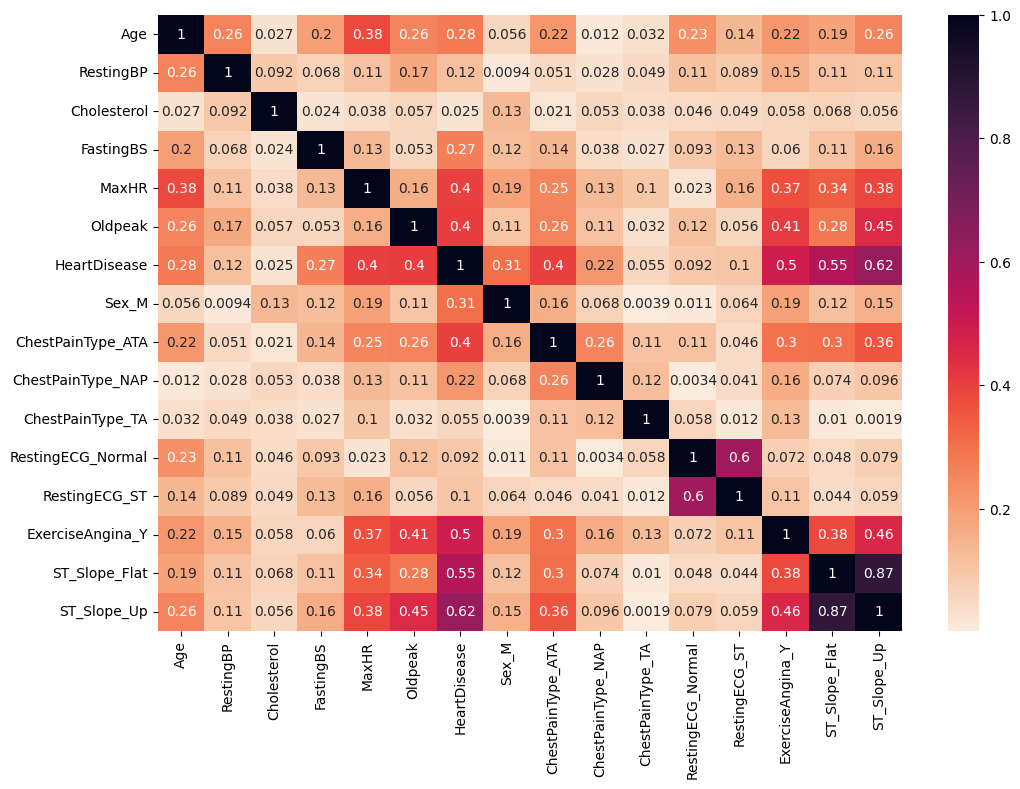

In [14]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="rocket_r")
plt.show()

Se visualiza con dificultad las correlaciones.luego reexpreso

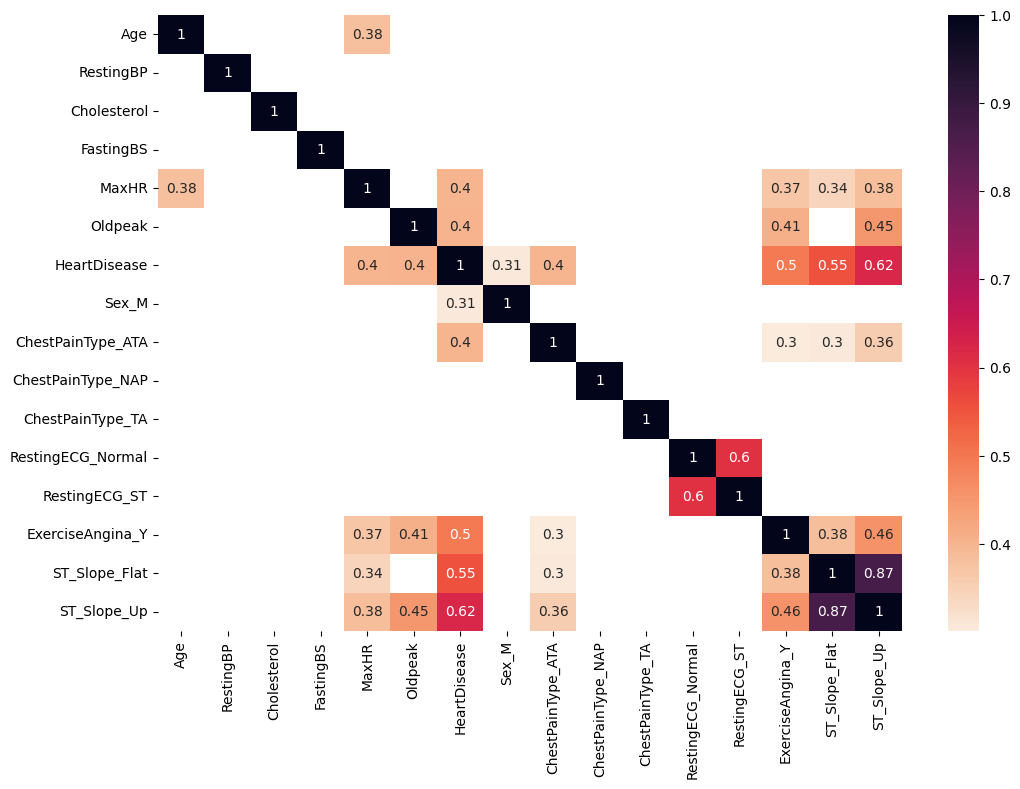

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.30], annot=True, cmap="rocket_r")
plt.show()

A partir de estas correlaciones, podemos identificar las características más fuertemente asociadas con la enfermedad cardíaca: Pendiente ST plana (0,52)
Pendiente ST ascendente (0,51)
Oldpeak (0,40)
Angina de pecho durante el ejercicio (0,39)
FC máxima (0,35)
Sexo masculino (0,30)

MACHINE LEARNIG FASE


In [16]:
# Split data into training and validation sets
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=417)

features = [
    "MaxHR",
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on MaxHR and with k = 3 has an accuracy of 66.67%
The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 76.81%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


Curiosamente, ST_Slope_Up es el mejor predictor individual con una precisión del 84,06%, seguido de ST_Slope_Flat con un 81,88%.Esto tiene sentido desde una perspectiva médica, ya que el segmento ST en un electrocardiograma está directamente relacionado con la función cardíaca.

Mofidiciaciones y criticas posbiles frente al anterior analisis ( train_test_split VS cross validation)
- Depende de la suerte: Al usar un solo train_test_split, el resultado puede variar según qué datos cayeron al azar en el entrenamiento. Lo ideal es usar Validación Cruzada (Cross-Validation).
- Falta escalado: KNN se basa en distancias. Es una buena práctica estandarizar los datos (aunque al usar una sola variable a la vez afecta menos, es mejor acostumbrarse).
- Es difícil de comparar: Leer una lista de textos es lento. Un gráfico de barras ordenado comunica la idea al instante.

/tmp/ipython-input-1539898643.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Accuracy', y='Feature', palette='viridis')


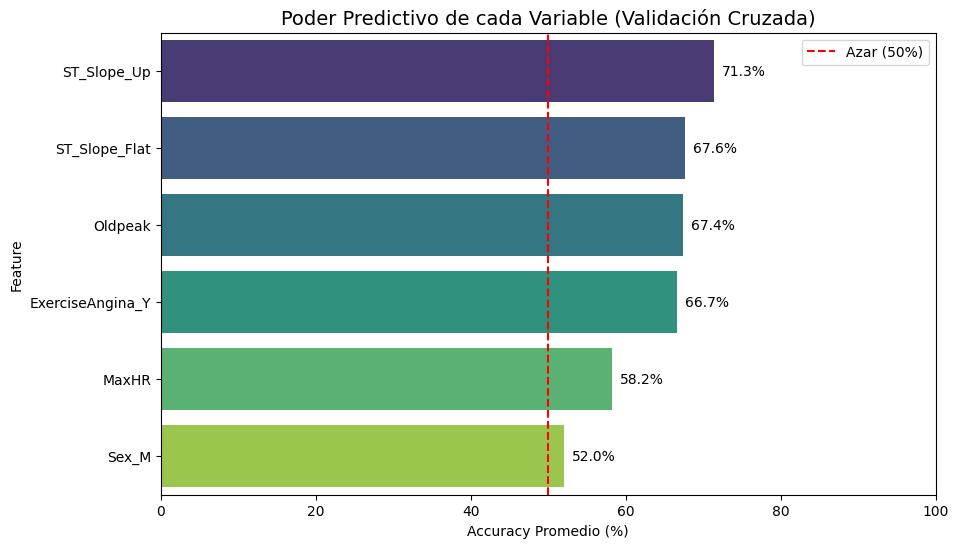

In [17]:
# 1. Definimos las columnas a probar
features = [
    "MaxHR", "Oldpeak", "Sex_M",
    "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"
]

results = []
scaler = StandardScaler() # Para escalar los datos (importante en KNN)

# 2. El Bucle mejorado
for feature in features:
    # Preparamos los datos (X) y la respuesta (y)
    X_feature = df_clean[[feature]]
    y = df_clean["HeartDisease"]

    # Escalamos los datos (StandardScaler)
    X_scaled = scaler.fit_transform(X_feature)

    # Inicializamos KNN (probamos con k=5, suele ser más estable que 3)
    knn = KNeighborsClassifier(n_neighbors=5)

    # 3. Validación Cruzada (Cross-Validation)
    # Divide los datos en 5 partes, entrena 5 veces y saca el promedio
    # Esto es mucho más científico que un solo split
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')

    # Guardamos el promedio de los 5 intentos
    results.append({
        'Feature': feature,
        'Accuracy': scores.mean() * 100
    })

# 4. Convertimos a DataFrame y ordenamos para el gráfico
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# 5. Visualización Profesional
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Accuracy', y='Feature', palette='viridis')
plt.title('Poder Predictivo de cada Variable (Validación Cruzada)', fontsize=14)
plt.xlabel('Accuracy Promedio (%)')
plt.xlim(0, 100) # Fijar el eje X de 0 a 100
plt.axvline(50, color='r', linestyle='--', label='Azar (50%)') # Línea de referencia
plt.legend()

# Mostrar etiquetas con el valor exacto
for index, value in enumerate(df_results['Accuracy']):
    plt.text(value + 1, index, f'{value:.1f}%', va='center')

plt.show()

**Multi-Feature Classifier**

Ahora, vamos a construir un modelo utilizando todas las características seleccionadas en conjunto. Dado que estamos utilizando el algoritmo de los K vecinos más cercanos, que se basa en cálculos de distancia, necesitamos escalar nuestras características para garantizar que contribuyan por igual:

In [18]:
# Scale the features to the same range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

# Build and evaluate the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 83.33


**Optimización de hiperparámetros**

Para mejorar nuestro modelo, exploremos diferentes combinaciones de hiperparámetros usando GridSearchCV. También refinaremos nuestra selección de características excluyendo Sex_M, que presentó la correlación más débil con la enfermedad cardíaca.



In [19]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = [
    "MaxHR",
    "Oldpeak",
    # "Sex_M",  # Testing whether this feature helps or hinders accuracy
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_train_scaled

array([[0.78169014, 0.42682927, 0.        , 0.        , 1.        ],
       [0.46478873, 0.42682927, 1.        , 1.        , 0.        ],
       [0.71126761, 0.48780488, 0.        , 1.        , 0.        ],
       ...,
       [0.26056338, 0.51219512, 1.        , 0.        , 1.        ],
       [0.15492958, 0.19512195, 0.        , 0.        , 1.        ],
       [0.59859155, 0.63414634, 0.        , 1.        , 0.        ]])

In [20]:
#hyperparameter grid
grid_params = {"n_neighbors": range(1, 20),
               "metric": ["minkowski", "manhattan"]
              }

# Perform grid search
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

# Display best parameters
print(f"Best score: {knn_grid.best_score_*100:.2f}%")
print(f"Best parameters: {knn_grid.best_params_}")

Best score: 82.80%
Best parameters: {'metric': 'manhattan', 'n_neighbors': 19}


Evaluación del modelo en el conjunto de prueba

 Finalmente, evaluemos nuestro modelo optimizado en el conjunto de prueba, que aún no hemos utilizado:

In [21]:
# Scale test data
X_test_scaled = scaler.transform(X_test[features])

# Make predictions on test set
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy on test set: {accuracy*100:.2f}%")

Model Accuracy on test set: 82.61%


In [22]:
# Check distribution of Sex_M
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


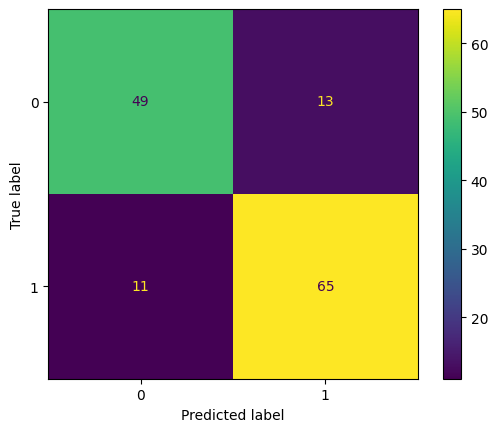

In [23]:
cf = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cf).plot()
plt.show()